In this Notebook, we go through some differential equation examples and how to solve them using neural networks

# First order ODE:

First Order ODE is defined in the form as:
\begin{equation}
    \frac{dy}{dx} + p(x)\cdot y = f(x)
\end{equation}

Where $x$ is defined between $0$ and $1$
\begin{equation}
    x \; \in \; [0, 1]
\end{equation}

And the boundary conidtion at 0:
\begin{equation}
    y(0) = A
\end{equation}

where $A$ is constant

# Solving ODE:

Finding the solution for the differential equation is the same as minimizing loss function ($min\{\mathcal{L} \}$), where the loss function is defined as:

\begin{equation}
    \mathcal{L} = \int_0^1 \left(\frac{d y}{dx} - f(x)\right)^2 dx
\end{equation}

# Neural Networks

\begin{equation}
    y \approx \mathcal{N}(x)
\end{equation}

Loss function:

\begin{equation}   
    MSE = MSE_f + MSE_u
\end{equation}

where the loss of the function is

\begin{equation}
    MSE_f = \frac{1}{N_f} \sum_{i=1}^{N_f} (\frac{d \mathcal{N}(x)}{dx}|_{x = x_i} - f(x_i))^2
\end{equation}

and the loss of the boundary conditions

\begin{equation}
    MSE_u = \frac{1}{N_u} \sum_{i=1}^{N_u} (\mathcal{N}(x_i) - y(x_i))^2
\end{equation}


## Building Neural Network 

In [324]:
import torch
import torch.nn as nn
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer = nn.Linear(1, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        layer_out = torch.sigmoid(self.hidden_layer(x))
        output = self.output_layer(layer_out)
        return output

In [325]:
model = ANN()
model

ANN(
  (hidden_layer): Linear(in_features=1, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

In [326]:
params = [p.numel() for p in model.parameters()]
params

[10, 10, 10, 1]

## Example Function and BC

\begin{equation}
    \begin{cases}
      f(x) = e^x\\
      p(x) = 0
    \end{cases}\,.
\end{equation}

\begin{equation}
    y(0) = 1
\end{equation}


### Exact Solution

\begin{equation}
    y = e^x
\end{equation}

In [469]:
model = ANN()
optimizer = torch.optim.LBFGS(model.parameters())

def exact_func(x):
    return torch.exp(x)

def f(x):
    return torch.exp(x)

def loss(model, x):
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    MSEf = torch.mean((dy_dx - f(x))**2)  #MSEf as defined above
    bc = (y[0, 0] - 1.)**2 #MSEu as defined above
    return MSEf + bc

# build random data points
x = torch.linspace(0, 1, 100)[:, None]

def closure():
    optimizer.zero_grad()
    l = loss(model, x)
    l.backward()
    return l

epochs = 10
for i in range(epochs):
    print("Epoch", str(i+1),", Loss: ",  loss(model, x).item())
    optimizer.step(closure)

print("Final Loss: ", loss(model, x).item())

Epoch 1 , Loss:  5.998648643493652
Epoch 2 , Loss:  0.0027858519461005926
Epoch 3 , Loss:  0.0200631245970726
Epoch 4 , Loss:  6.401992141036317e-05
Epoch 5 , Loss:  3.448730785748921e-05
Epoch 6 , Loss:  3.105203722952865e-05
Epoch 7 , Loss:  4.77506091556279e-06
Epoch 8 , Loss:  3.210107024642639e-08
Epoch 9 , Loss:  3.210107024642639e-08
Epoch 10 , Loss:  3.210107024642639e-08
Final Loss:  3.210107024642639e-08


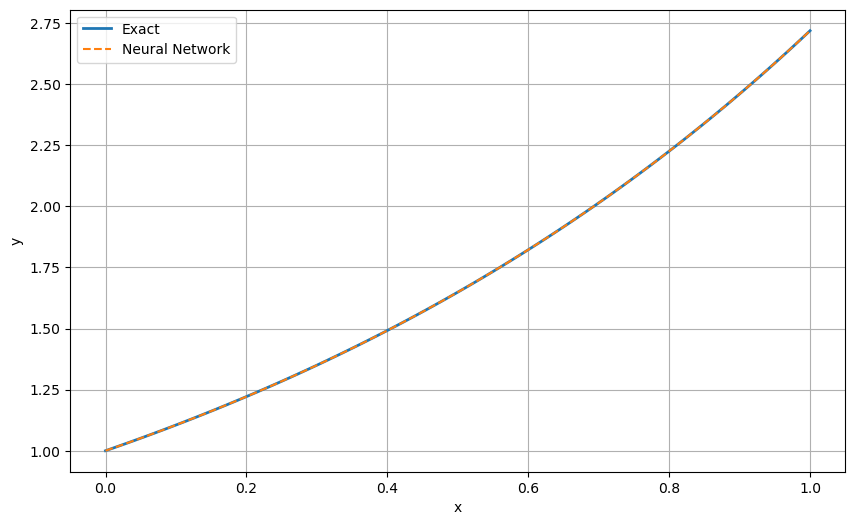

In [516]:
import matplotlib.pyplot as plt

xtest = torch.linspace(0, 1, 100)[:, None]
with torch.no_grad():
    ypred = model(xtest)

plt.figure(figsize=(10, 6))
plt.plot(xtest, exact_func(xtest), label="Exact", linewidth=2.0)
plt.plot(xtest, ypred, '--' ,label="Neural Network")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.savefig("report_modeling2.pdf", bbox_inches='tight')
plt.show()

# Second order ODE:

\begin{equation}
    \frac{d^2 y}{dx^2} + p(x) \frac{dy}{dx} + q(x) y = f(x)
\end{equation}

\begin{equation}
    x \; \in \; [0, 1]
\end{equation}

\begin{equation}
    y(0) = A
\end{equation}

\begin{equation}
    y(1) = B
\end{equation}

## Example Function and BC

\begin{equation}
    \begin{cases}
      p(x) = 0\\
      q(x) = 0\\
      f(x) = -1
    \end{cases}\,.
\end{equation}

\begin{equation}
    \begin{cases}
      y(0) = 0\\
      y(1) = 0
    \end{cases}\,.
\end{equation}

### Exact Solution

\begin{equation}
    y(x) = - \frac{1}{2}x^2 + \frac{1}{2}x
\end{equation}

In [517]:
model = ANN()
optimizer = torch.optim.LBFGS(model.parameters())


def f(x):
    return -torch.ones(x.shape[0], x.shape[1])


def exact_func(x):
    return -0.5*torch.pow(x, 2) + 0.5*x


def loss(model, x):
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    y_double_prime = torch.autograd.grad(dy_dx.sum(), x, create_graph=True)[0]
    
    MSEf = torch.mean((y_double_prime - f(x))**2) #MSEf
    bc1 = 0.5*(y[0, 0] - 0.)**2 #MSEu1
    bc2 = 0.5*(y[-1, 0] - 0.)**2 #MSEu2
    return  MSEf + bc1 + bc2


# Build some random data points
x = torch.linspace(0, 1, 100)[:, None]

def closure():
    optimizer.zero_grad()
    l = loss(model, x)
    l.backward()
    return l

epochs = 10
for i in range(epochs):
    print("Epoch", str(i+1),", Loss: ",  loss(model, x).item())
    optimizer.step(closure)
    
print("Final Loss: ", loss(model, x).item())

Epoch 1 , Loss:  1.1224342584609985
Epoch 2 , Loss:  0.039000704884529114
Epoch 3 , Loss:  0.002222726820036769
Epoch 4 , Loss:  0.0008910264587029815
Epoch 5 , Loss:  0.00013392374967224896
Epoch 6 , Loss:  2.8445592761272565e-05
Epoch 7 , Loss:  3.167259592373739e-07
Epoch 8 , Loss:  3.1425392421624565e-07
Epoch 9 , Loss:  3.1425392421624565e-07
Epoch 10 , Loss:  3.1425392421624565e-07
Final Loss:  3.1425392421624565e-07


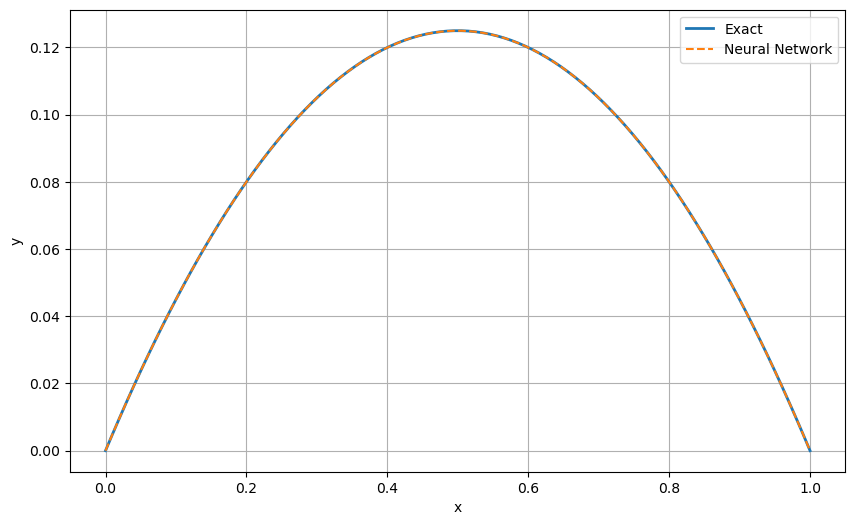

In [518]:
import matplotlib.pyplot as plt

xtest = torch.linspace(0, 1, 100)[:, None]
with torch.no_grad():
    ypred = model(xtest)

plt.figure(figsize=(10, 6))
plt.plot(xtest, exact_func(xtest), label="Exact", linewidth=2.0)
plt.plot(xtest, ypred, '--' ,label="Neural Network")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.savefig("report_modeling2.pdf", bbox_inches='tight')
plt.show()

Sources: https://www.sciencedirect.com/science/article/pii/S0021999118307125

## Exponnetial Decay

An exponential decay of a quantity $g(x)$ is described by the equation

$$
 g'(x) = -\gamma g(x)
$$


with $g(0) = g_0$ for some chosen initial value $g_0$.

The exact solution of exponential growth equation is

$$
g(x) = g_0 \exp\left(-\gamma x\right)
$$


Where (example) $\gamma = 2$ and $g0 = 10$ (This can change)

We can notice that BC1 is $g(0) = g_0$

We can build two losses here: first loss is MSEf is the loss of the quation 

$$
g'(x) = -\gamma g(x)
$$

Where we minimize the differnece between the two terms

and the second loss is the boundary condition loss where  

$$
g(0) = g_0
$$


In [370]:
model = ANN()
optimizer = torch.optim.LBFGS(model.parameters())

def exact_func(x, g0=10, gamma=2):
    return g0*torch.exp(-gamma*x)

def loss(model, x):
    g0 = 10
    gamma = 2
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    
    MSEf = torch.mean((dy_dx + gamma * y)**2) #MSEf
    bc1 = (y[0, 0] - g0)**2 #MSEu1
    return  MSEf + bc1

# Build some random data points
x = torch.linspace(0, 1, 100)[:, None]

def closure():
    optimizer.zero_grad()
    l = loss(model, x)
    l.backward()
    return l

epochs = 10
for i in range(epochs):
    print("Epoch", str(i+1),", Loss: ",  loss(model, x).item())
    optimizer.step(closure)
    
print("Final Loss: ", loss(model, x).item())

Epoch 1 , Loss:  99.2746810913086
Epoch 2 , Loss:  0.06758072972297668
Epoch 3 , Loss:  0.00022502343927044421
Epoch 4 , Loss:  0.00015898648416623473
Epoch 5 , Loss:  1.2838418115279637e-05
Epoch 6 , Loss:  2.6046413950098213e-06
Epoch 7 , Loss:  2.603606617412879e-06
Epoch 8 , Loss:  2.603606617412879e-06
Epoch 9 , Loss:  2.603606617412879e-06
Epoch 10 , Loss:  2.603606617412879e-06
Final Loss:  2.603606617412879e-06


In [410]:
#forward Euler
import numpy as np
Nt = 100
g0 = 10
T = 1
t = np.linspace(0, 1, Nt)
dt = T/(Nt - 1)

yeuler = np.zeros(Nt)
yeuler[0] = g0

for i in range(1, Nt):
    yeuler[i] = yeuler[i-1] - dt*(alpha*yeuler[i-1])

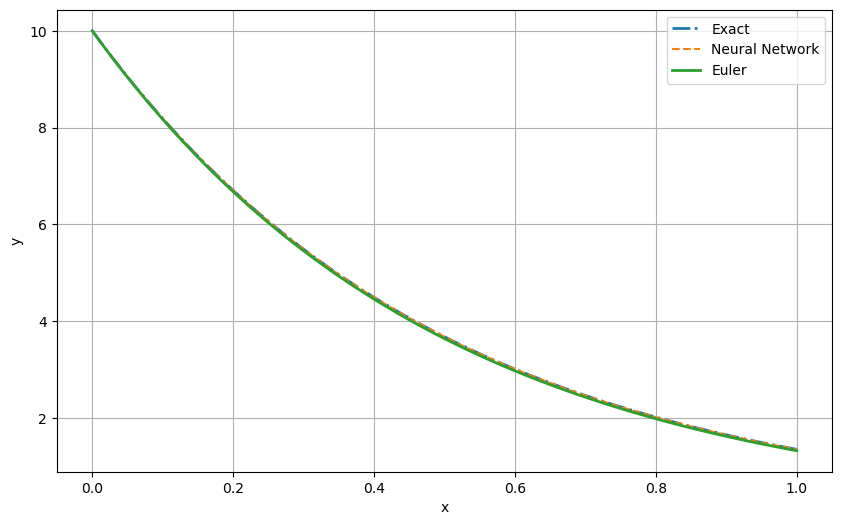

In [411]:
import matplotlib.pyplot as plt

xtest = torch.linspace(0, 1, 100)[:, None]
with torch.no_grad():
    ypred = model(xtest)

plt.figure(figsize=(10, 6))
plt.plot(xtest, exact_func(xtest), '-.', label="Exact", linewidth=2.0)
plt.plot(xtest, ypred, '--' ,label="Neural Network")
plt.plot(xtest, yeuler ,label="Euler", linewidth=2.0)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.savefig("report_modeling2.pdf", bbox_inches='tight')
plt.show()

In [412]:
MSE_euler = ((yeuler - exact_func(xtest).detach().numpy())**2).mean()
MSE_NN = ((ypred - exact_func(xtest).detach().numpy())**2).mean()
print("MSE between Euler and exact: ", MSE_euler)
print("MSE between NN and exact: ", MSE_NN.detach().numpy())

MSE between Euler and exact:  12.031399549321169
MSE between NN and exact:  8.4516625e-09


## Population Growth

$$
g'(t) = \alpha g(t)(A - g(t))
$$

where $g(0) = g_0$.

In this example, we let $\alpha = 2$, $A = 1$, and $g_0 = 1.2$.

Exact solution is given as:

$$
g'(t) = Ag_0/(g_0+ (A-g_0)\exp(-\alpha A x)
$$

In [333]:
model = ANN()
optimizer = torch.optim.LBFGS(model.parameters())

# Those can be changed
g0 = 1.2
alpha = 2
A = 1

def exact_func(x):
    alpha, A, g0 = 2, 1, 1.2 
    return A*g0/(g0 + (A - g0)*torch.exp(-alpha*A*x))

def loss(model, x):
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    
    MSEf = torch.mean((dy_dx - (alpha * y * (A - y)))**2) #MSEf
    bc1 = (y[0, 0] - g0)**2 #MSEu1
    return  MSEf + bc1

# Build some random data points
x = torch.linspace(0, 1, 100)[:, None]

def closure():
    optimizer.zero_grad()
    l = loss(model, x)
    l.backward()
    return l

epochs = 10
for i in range(epochs):
    print("Epoch", str(i+1),", Loss: ",  loss(model, x).item())
    optimizer.step(closure)
    
print("Final Loss: ", loss(model, x).item())

Epoch 1 , Loss:  3.439047336578369
Epoch 2 , Loss:  0.012857181020081043
Epoch 3 , Loss:  0.0038709519430994987
Epoch 4 , Loss:  0.0009571144473738968
Epoch 5 , Loss:  0.0008425815613009036
Epoch 6 , Loss:  3.510626993374899e-05
Epoch 7 , Loss:  2.8446900614653714e-05
Epoch 8 , Loss:  1.1659221854642965e-05
Epoch 9 , Loss:  8.231028914451599e-06
Epoch 10 , Loss:  5.349894308892544e-06
Final Loss:  3.92878109778394e-06


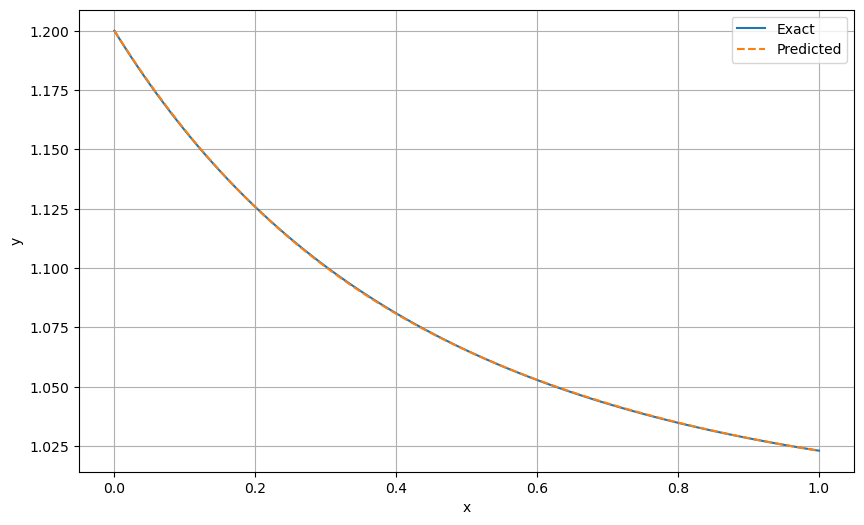

<Figure size 640x480 with 0 Axes>

In [334]:
import matplotlib.pyplot as plt

xtest = torch.linspace(0, 1, 100)[:, None]
with torch.no_grad():
    ypred = model(xtest)

plt.figure(figsize=(10, 6))
plt.plot(xtest, exact_func(xtest), label="Exact")
plt.plot(xtest, ypred, '--' ,label="Predicted")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()
plt.savefig("pop_growth_example.pdf", bbox_inches='tight')

## Poisson equation

$$
  -g''(x) = f(x)
$$


BC1 

$$
g(0) = 0
$$

BC2

$$
g(1) = 0
$$

In [519]:
model = ANN()
optimizer = torch.optim.LBFGS(model.parameters())

# Those can be changed
g0 = 1.2
alpha = 2
A = 1

def exact_func(x):
    return x*(1-x)*torch.exp(x)

def f(x):
    return (3*x + x**2)*torch.exp(x)

def loss(model, x):
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    y_double_prime = torch.autograd.grad(dy_dx.sum(), x, create_graph=True)[0]
    
    MSEf = torch.mean((y_double_prime + f(x))**2) #MSEf
    bc1 = (y[0, 0] - 0)**2 #MSEu1
    bc2 = (y[-1, 0] - 0)**2 #MSEu2
    return  MSEf + bc1 + bc2

# Build some random data points
x = torch.linspace(0, 1, 100)[:, None]

def closure():
    optimizer.zero_grad()
    l = loss(model, x)
    l.backward()
    return l

epochs = 9
for i in range(epochs):
    print("Epoch", str(i+1),", Loss: ",  loss(model, x).item())
    optimizer.step(closure)
    
print("Final Loss: ", loss(model, x).item())

Epoch 1 , Loss:  23.4923095703125
Epoch 2 , Loss:  8.068517684936523
Epoch 3 , Loss:  0.007823645137250423
Epoch 4 , Loss:  8.335307938978076e-05
Epoch 5 , Loss:  3.829570687230444e-06
Epoch 6 , Loss:  1.2836039786634501e-06
Epoch 7 , Loss:  1.2836039786634501e-06
Epoch 8 , Loss:  1.2836039786634501e-06
Epoch 9 , Loss:  1.2836039786634501e-06
Final Loss:  1.2836039786634501e-06


In [544]:
def f(x):
    return (3*x + x**2)*np.exp(x)

Nx = 100
x = np.linspace(0,1, Nx)
    
dx = 1/(Nx - 1)

# Set up the matrix A
A = np.zeros((Nx-2,Nx-2))

A[0,0] = 2
A[0,1] = -1

for i in range(1,Nx-3):
    A[i,i-1] = -1
    A[i,i] = 2
    A[i,i+1] = -1

A[Nx - 3, Nx - 4] = -1
A[Nx - 3, Nx - 3] = 2

# Set up the vector f
f_vec = dx**2 * f(x[1:-1])

# Solve the equation
#g_res = np.linalg.solve(A, f_vec)

#g_vec = np.zeros(Nx)
#g_vec[1:-1] = g_res

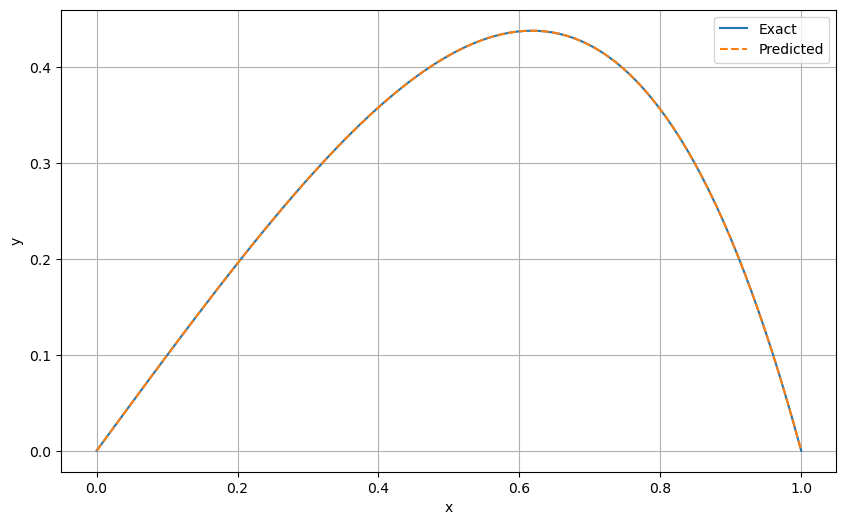

In [546]:
import matplotlib.pyplot as plt

xtest = torch.linspace(0, 1, 100)[:, None]
with torch.no_grad():
    ypred = model(xtest)

plt.figure(figsize=(10, 6))
plt.plot(xtest, exact_func(xtest), label="Exact")
plt.plot(xtest, ypred, '--' ,label="Predicted")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.savefig("report_modeling3.pdf", bbox_inches='tight')
plt.show()

## Sample ODE
$$
y =−2xy
$$

Exact solution is 

$$
y(x)=exp−x^2
$$

and BC1 

$$
y(0) = 1
$$

In [339]:
model = ANN()
optimizer = torch.optim.LBFGS(model.parameters())

# Those can be changed

def exact_func(x):
    return torch.exp(-x**2)

def loss(model, x):
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    
    MSEf = torch.mean((dy_dx + 2*x*y)**2) #MSEf
    bc1 = (y[0, 0] - 1)**2 #MSEu1
    #bc2 = (y[-1, 0] - 1)**2 #MSEu1
    return  MSEf + bc1

# Build some random data points
x = torch.linspace(0, 1, 100)[:, None]

def closure():
    optimizer.zero_grad()
    l = loss(model, x)
    l.backward()
    return l

epochs = 15
for i in range(epochs):
    print("Epoch", str(i+1),", Loss: ",  loss(model, x).item())
    optimizer.step(closure)
    
print("Final Loss: ", loss(model, x).item())

Epoch 1 , Loss:  0.6602413654327393
Epoch 2 , Loss:  0.022572124376893044
Epoch 3 , Loss:  0.0009475370170548558
Epoch 4 , Loss:  1.4480426671070745e-06
Epoch 5 , Loss:  2.9888599328842247e-07
Epoch 6 , Loss:  2.9888599328842247e-07
Epoch 7 , Loss:  2.9888599328842247e-07
Epoch 8 , Loss:  2.9888599328842247e-07
Epoch 9 , Loss:  2.9888599328842247e-07
Epoch 10 , Loss:  2.9888599328842247e-07
Epoch 11 , Loss:  2.9888599328842247e-07
Epoch 12 , Loss:  2.9888599328842247e-07
Epoch 13 , Loss:  2.9888599328842247e-07
Epoch 14 , Loss:  2.9888599328842247e-07
Epoch 15 , Loss:  2.9888599328842247e-07
Final Loss:  2.9888599328842247e-07


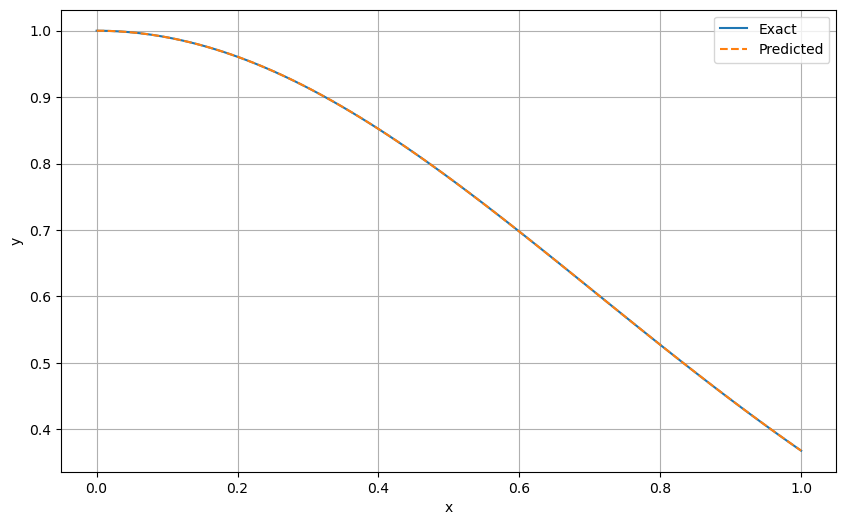

<Figure size 640x480 with 0 Axes>

In [340]:
import matplotlib.pyplot as plt

xtest = torch.linspace(0, 1, 100)[:, None]
with torch.no_grad():
    ypred = model(xtest)

plt.figure(figsize=(10, 6))
plt.plot(xtest, exact_func(xtest), label="Exact")
plt.plot(xtest, ypred, '--' ,label="Predicted")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()
plt.savefig("sample_example.pdf", bbox_inches='tight')

## Sine Wave

$$
y_{trial}(t)= A + x*f(x)
$$

and the BC is 
$$
y(0)= 0
$$

and $A = 0$

In [585]:
model = ANN()
optimizer = torch.optim.LBFGS(model.parameters())

def exact_func(x):
    return torch.exp(-(x/5.0))*torch.sin(x)

A = 0
yt = lambda x: A + x * model(x) #trial solution

def f(model, x):
    yt_ = yt(x)
    tr = torch.exp(-x / 5.0) * torch.cos(x) - yt_ / 5.0
    return tr

def loss(model, x):
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    yt = f(model, x)
    
    MSEf = torch.mean(((y+x*dy_dx) - yt)**2) #MSEf
    bc1 = (y[0, 0] - 0)**2 #MSEu1
    return  MSEf + bc1

# Build some random data points between 0, 5
x = torch.linspace(0, 10, 100)[:, None]

def closure():
    optimizer.zero_grad()
    l = loss(model, x)
    l.backward()
    return l

epochs = 10
for i in range(epochs):
    print("Epoch", str(i+1),", Loss: ",  loss(model, x).item())
    optimizer.step(closure)
    
print("Final Loss: ", loss(model, x).item())

Epoch 1 , Loss:  0.6197128295898438
Epoch 2 , Loss:  0.10548285394906998
Epoch 3 , Loss:  0.03385336697101593
Epoch 4 , Loss:  0.035268593579530716
Epoch 5 , Loss:  0.02210547775030136
Epoch 6 , Loss:  0.023813385516405106
Epoch 7 , Loss:  0.014505281113088131
Epoch 8 , Loss:  0.01338265836238861
Epoch 9 , Loss:  0.012492752633988857
Epoch 10 , Loss:  0.011967922560870647
Final Loss:  0.011821438558399677


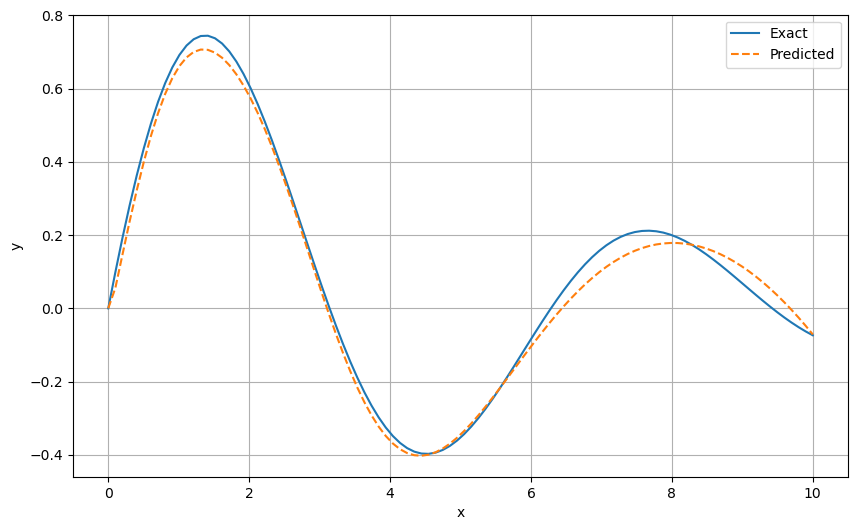

In [586]:
import matplotlib.pyplot as plt

xtest = torch.linspace(0, 10, 100)[:, None]
with torch.no_grad():
    ypred = yt(xtest)

plt.figure(figsize=(10, 6))
plt.plot(xtest, exact_func(xtest), label="Exact")
plt.plot(xtest, ypred, '--' ,label="Predicted")

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.savefig("report_modeling5.pdf", bbox_inches='tight')
plt.show()

## References:

https://sevent-christina.medium.com/deep-learning-solves-differential-equations-better-than-any-other-numerical-method-14126c7a2a7c

https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/chapter11.html

https://github.com/ComputationalDomain/PINNs/blob/main/ODE_Neural_Networks.ipynb